In [1]:
import numpy as np
from skimage import io, morphology, measure
from skimage.io import imread
import os
from scipy.ndimage import binary_dilation, generate_binary_structure
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
from skimage import morphology
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
from scipy.spatial import distance
from skimage.transform import resize
from PIL import Image
from skimage.measure import find_contours
from scipy import stats

ctrl - mean: 31.621725000000005, std: 4.127855411636289, COV: 13.053859053028539%
critical value (mean COV + std COV): 17.18171446466483%

P-values for SU5402 vs Ctrl for each somite:
Somite 1: p-value = 0.3626307378385293
Somite 2: p-value = 0.0025425262630349534
Somite 3: p-value = 0.0733915025415962
Somite 4: p-value = 0.8639104457774216
Somite 5: p-value = 0.5906193770827426
Somite 6: p-value = 0.3923749943492125
Somite 7: p-value = 0.07762276522018624
Somite 8: p-value = 0.03670102602568886
Somite 9: p-value = 0.5810789878009524
Somite 10: p-value = 0.644675665910581


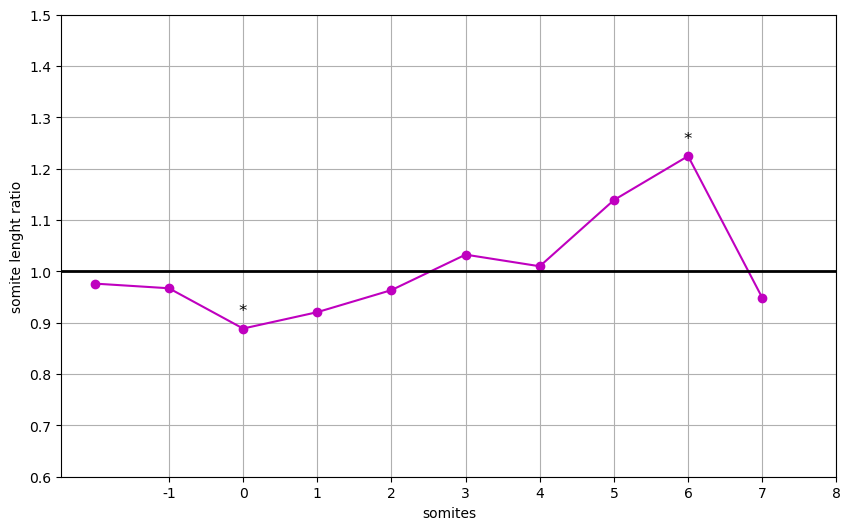

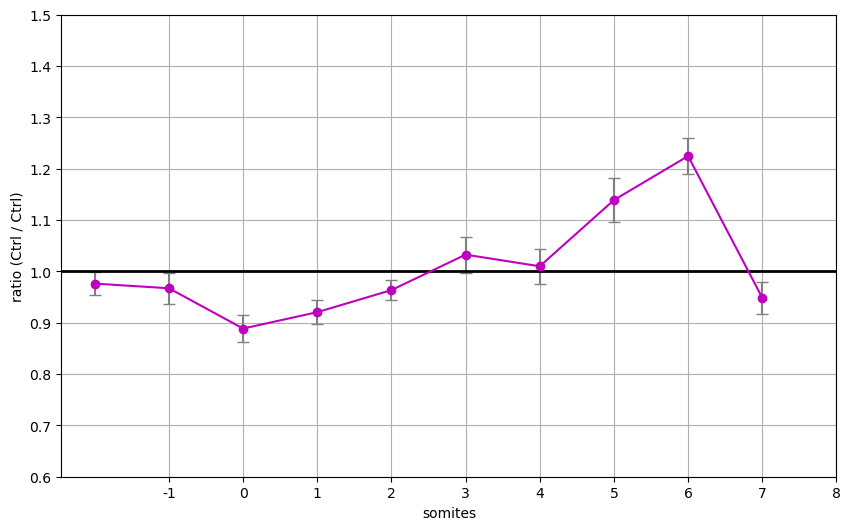

In [ ]:
def calculate_mean_somite(directory):
    length_single_somite = {i: [] for i in range(1, 11)}
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            for i in range(1, 11):
                length_single_somite[i].append(df.loc[i-1, 'Length']) 
    mean = [sum(length_single_somite[i])/len(length_single_somite[i]) for i in range(1, 11)]
    return mean

# Funzione per calcolare la media, deviazione standard e coefficiente di variazione
def calculate_mean_and_cov(directory):
    all_lengths = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            all_lengths.extend(df['Length'].tolist())  # Raccolgo tutte le lunghezze
    mean = np.mean(all_lengths)
    std_dev = np.std(all_lengths)
    cov = (std_dev / mean) * 100  # COV come percentuale
    return mean, std_dev, cov

# Funzione per calcolare i p-values tra il gruppo di controllo e il trattamento
def calculate_p_values(ctrl_data, treatment_data):
    p_values = []
    for i in range(1, 11):
        ctrl_values = ctrl_data[i]
        treatment_values = treatment_data[i]
        _, p_value = stats.ttest_ind(ctrl_values, treatment_values)
        p_values.append(p_value)
    return p_values

# Funzione per tracciare il rapporto con asterischi per valori significativi
def plot_with_significance(x, y, p_values, threshold=0.05, color='m', xlabel='somites after treatment', ylabel='somite lenght ratio', save_path_svg='', save_path_tiff=''):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color=color)
    plt.axhline(y=1, color='black', linestyle='-', linewidth=2)
    plt.ylim(0.6, 1.5)
    
    # Aggiungi l'asterisco per valori significativi
    for i in range(len(x)):
        if p_values[i] < threshold:
            plt.text(x[i], y[i] + 0.02, '*', ha='center', va='bottom', fontsize=12, color='black') 

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks=range(10), labels=[f"{-i+9}" for i in range(1, 11)])
    plt.gca().invert_xaxis()
    plt.grid(True)
    
    # Salva il grafico nei formati richiesti
    plt.savefig(save_path_svg, format='svg')
    plt.savefig(save_path_tiff, format='tiff')
    plt.show()

# Directory dei dati
ctrl = 'H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/ctrl_22ss/'  
#su5402 = 'H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/ctrl/ctrl3/'
su5402 = 'H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/su_22ss/'

# Calcola media, deviazione standard e COV per il controllo
mean_ctrl, std_ctrl, cov_ctrl = calculate_mean_and_cov(ctrl)
print(f"ctrl - mean: {mean_ctrl}, std: {std_ctrl}, COV: {cov_ctrl}%")
critical_value = cov_ctrl + std_ctrl
print(f"critical value (mean COV + std COV): {critical_value}%")

# Calcola la media dei somiti per i gruppi
mean_ctrl = calculate_mean_somite(ctrl)
mean_su5402 = calculate_mean_somite(su5402)

# Verifica che i dati abbiano 10 valori per somite
assert len(mean_ctrl) == 10 
assert len(mean_su5402) == 10 

# Raccolgo i dati per ogni somite
ctrl_data = {i: [] for i in range(1, 11)}
su5402_data = {i: [] for i in range(1, 11)}
pd17_data = {i: [] for i in range(1, 11)}

# Carica i dati per ogni somite e gruppo
for file in os.listdir(ctrl):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(ctrl, file))
        for i in range(1, 11):
            ctrl_data[i].append(df.loc[i-1, 'Length'])  # Aggiungi lunghezze per il controllo
            
for file in os.listdir(su5402):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(su5402, file))
        for i in range(1, 11):
            su5402_data[i].append(df.loc[i-1, 'Length'])  # Aggiungi lunghezze per SU5402

# Calcola i p-values per SU5402 rispetto al controllo
p_values_su5402 = calculate_p_values(ctrl_data, su5402_data)

# Stampa i p-values per ogni somite
print("\nP-values for SU5402 vs Ctrl for each somite:")
for i, p in enumerate(p_values_su5402, 1):
    print(f"Somite {i}: p-value = {p}")

# Salvataggio dei p-values in un file CSV
p_values_df = pd.DataFrame({
    'Somite': list(range(1, 11)),
    'p-value_SU5402': p_values_su5402,
})
p_values_df.to_csv('H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/res_new/p_values_su_22ss.csv', index=False)

# Traccia e salva i grafici per i rapporti SU5402/Ctrl con significatività
plot_with_significance(
    x=list(range(1, 11)),
    y=[su5402_val / ctrl_val if ctrl_val != 0 else 0 for su5402_val, ctrl_val in zip(mean_su5402, mean_ctrl)],
    p_values=p_values_su5402,
    color='m',
    xlabel='somites',
    save_path_svg='H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/res_new/ratio_su_22ss.svg',
    save_path_tiff='H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/res_new/ratio_su_22ss.tif'
)

def plot_with_error(x, y, y_errors, color='m', xlabel='somites after treatment', ylabel='somite lenght ratio', save_path_svg='', save_path_tiff=''):
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=y_errors, fmt='o-', color=color, ecolor='gray', elinewidth=1.5, capsize=4)
    plt.axhline(y=1, color='black', linestyle='-', linewidth=2)
    plt.ylim(0.6, 1.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks=range(10), labels=[f"{-i+9}" for i in range(1, 11)])
    plt.gca().invert_xaxis()
    plt.grid(True)

    # Salva il grafico nei formati richiesti
    plt.savefig(save_path_svg, format='svg')
    plt.savefig(save_path_tiff, format='tiff')
    plt.show()

std_errors_su5402_ratio = [
    (np.std(su5402_data[i], ddof=1) / np.sqrt(len(su5402_data[i]))) / mean_ctrl[i-1]  # Scala rispetto alla media Ctrl
    for i in range(1, 11)
]

plot_with_error(
    x=list(range(1, 11)),
    y=[su5402_val / ctrl_val if ctrl_val != 0 else 0 for su5402_val, ctrl_val in zip(mean_su5402, mean_ctrl)],
    y_errors=std_errors_su5402_ratio,  # Barre di errore scalate
    color='m',
    xlabel='somites',
    ylabel='ratio (Ctrl / Ctrl)',
    save_path_svg='H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/res_new/su_22ss.svg',
    save_path_tiff='H:/PROJECTS-03/Agnese/20250117_wtabxtl_fgfinhpulse/measures/res_new/su_22ss.tif'
)

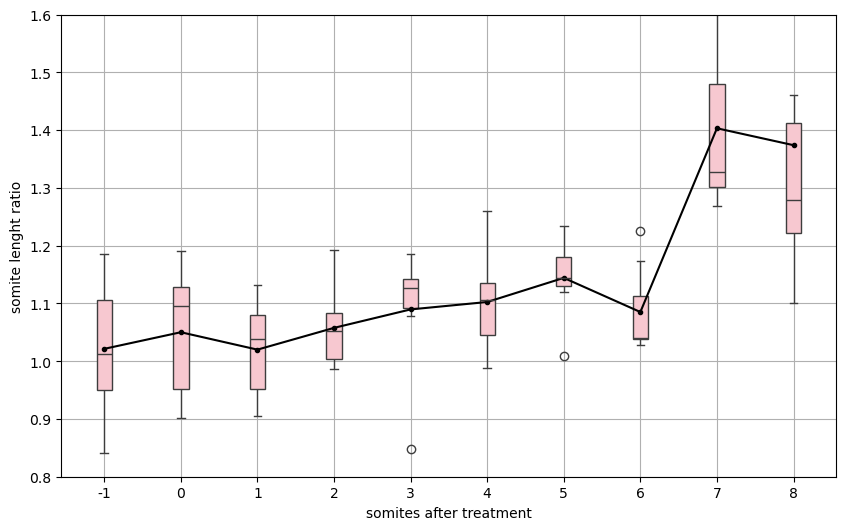

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

# Funzione per calcolare la media dei somiti
def calculate_mean_somite(directory):
    length_single_somite = {i: [] for i in range(1, 11)}
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            for i in range(1, 11):
                length_single_somite[i].append(df.loc[i-1, 'Length']) 
    mean = [sum(length_single_somite[i])/len(length_single_somite[i]) for i in range(1, 11)]
    return mean

# Funzione per calcolare i p-values tra il gruppo di controllo e il trattamento
def calculate_p_values(ctrl_data, treatment_data):
    p_values = []
    for i in range(1, 11):
        ctrl_values = ctrl_data[i]
        treatment_values = treatment_data[i]
        _, p_value = stats.ttest_ind(ctrl_values, treatment_values)
        p_values.append(p_value)
    return p_values

# Funzione per tracciare boxplot con asterischi per valori significativi
def plot_boxplot_with_significance_ratio(ctrl_data, su5402_data, threshold=0.05, xlabel='somites after treatment', ylabel='somite lenght ratio', save_path_svg='', save_path_tiff=''):
    plt.figure(figsize=(10, 6))

    # Calcola i rapporti tra i dati di SU5402 e Ctrl
    ratios = []
    for i in range(1, 11):
        ratio = [su5402_val / ctrl_val if ctrl_val != 0 else 0 for su5402_val, ctrl_val in zip(su5402_data[i], ctrl_data[i])]
        ratios.append(ratio)

    # Crea il boxplot dei rapporti con lo stesso colore per ogni boxplot
    sns.boxplot(data=ratios, color="pink", width=0.2)  # Using a single color

    # Aggiungi l'asterisco per valori significativi
    #for i in range(1, 11):
        #if p_values[i-1] < threshold:  # Se il p-value è inferiore alla soglia, aggiungi un asterisco
            #plt.text(i - 1, max(ratios[i-1]) + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')

    # Aggiungi una linea per la media dei rapporti
    mean_ratios = [np.mean(ratio) for ratio in ratios]
    plt.plot(range(10), mean_ratios, color='black', marker='.')
    plt.ylim(0.8, 1.6)

    # Etichette e titolo
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Update the x-ticks and labels to range from -1 to 8
    plt.xticks(ticks=range(10), labels=[f"{-i+9}" for i in range(1, 11)])  # This will give the labels -1 to 8

    # Reverse the x-axis
    plt.gca().invert_xaxis()
    plt.grid(True)

    # Salva il grafico nei formati richiesti
    plt.savefig(save_path_svg, format='svg')
    plt.savefig(save_path_tiff, format='tiff')

    # Mostra il grafico
    plt.show()

# Directory dei dati
ctrl = 'H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/ctrl22ss/'  
#su5402 = 'H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/ctrl/ctrl2/'
su5402 = 'H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/22ss/'


# Calcola la media dei somiti per il controllo
mean_ctrl = calculate_mean_somite(ctrl)
mean_su5402 = calculate_mean_somite(su5402)

# Verifica che i dati abbiano 10 valori per somite
assert len(mean_ctrl) == 10 
assert len(mean_su5402) == 10 

# Raccolgo i dati per ogni somite e gruppo
ctrl_data = {i: [] for i in range(1, 11)}
su5402_data = {i: [] for i in range(1, 11)}

# Carica i dati per ogni somite e gruppo
for file in os.listdir(ctrl):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(ctrl, file))
        for i in range(1, 11):
            ctrl_data[i].append(df.loc[i-1, 'Length'])  # Aggiungi lunghezze per il controllo
            
for file in os.listdir(su5402):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(su5402, file))
        for i in range(1, 11):
            su5402_data[i].append(df.loc[i-1, 'Length'])  # Aggiungi lunghezze per SU5402

# Calcola i p-values per SU5402 rispetto al controllo
p_values_su5402 = calculate_p_values(ctrl_data, su5402_data)

# Stampa i p-values per ogni somite
#print("\nP-values for SU5402 vs Ctrl for each somite:")
#for i, p in enumerate(p_values_su5402, 1):
    #print(f"Somite {i}: p-value = {p}")

# Salvataggio dei p-values in un file CSV
#p_values_df = pd.DataFrame({
    #'Somite': list(range(1, 11)),
    #'p-value_SU5402': p_values_su5402,
#})
#p_values_df.to_csv('H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/p_values_22ss.csv', index=False)

# Traccia e salva il boxplot del rapporto con significatività
plot_boxplot_with_significance_ratio(
    ctrl_data=ctrl_data,
    su5402_data=su5402_data,
    #p_values=p_values_su5402,
    xlabel='somites after treatment',
    ylabel='somite lenght ratio',
    save_path_svg='H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/res_new/boxplot_ctrl_22ss.svg',
    save_path_tiff='H:/PROJECTS-03/Agnese/20250205_wtabxtl_fgfinhpulse/measures/res_new/boxplot_ctrl_22ss.tiff'
)

ctrl - mean: 30.239933333333333, std: 3.786002270939038, COV: 12.519876380698717%
critical value (mean COV + std COV): 16.305878651637755%


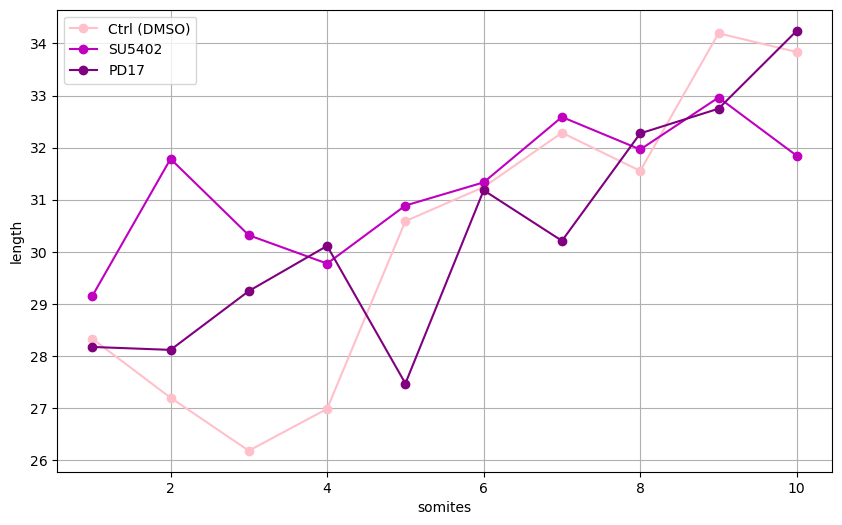

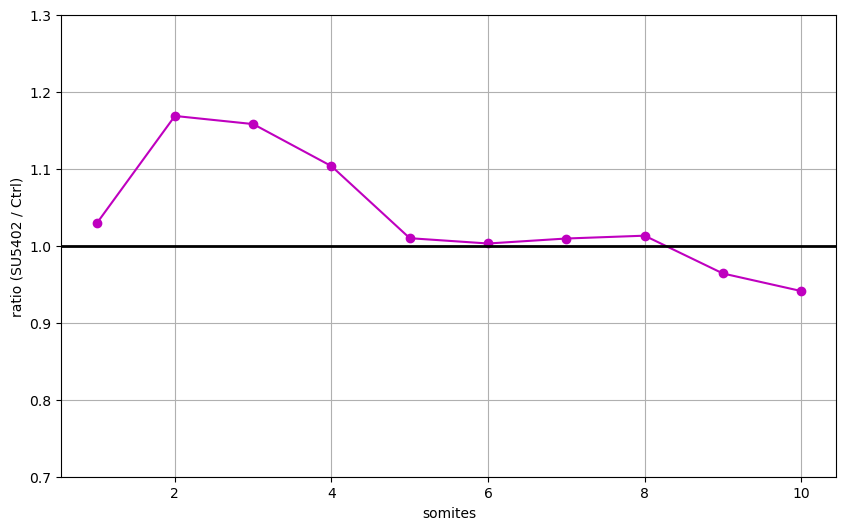

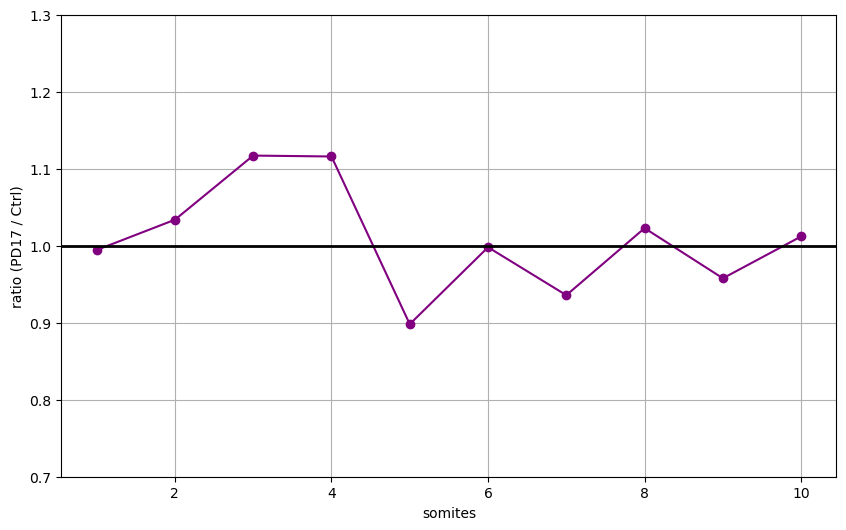

In [50]:
def calculate_mean_somite(directory):
    lenght_single_somite = {i: [] for i in range(1, 11)}
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            for i in range(1, 11):
                lenght_single_somite[i].append(df.loc[i-1, 'Length']) 
    mean = [sum(lenght_single_somite[i])/len(lenght_single_somite[i]) for i in range(1, 11)]
    return mean

def calculate_mean_and_cov(directory):
    all_lengths = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            all_lengths.extend(df['Length'].tolist())  # Raccolgo tutte le lunghezze
    mean = np.mean(all_lengths)
    std_dev = np.std(all_lengths)
    cov = (std_dev / mean) * 100  # COV come percentuale
    return mean, std_dev, cov

ctrl = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/ctrl_30ss/'  
su5402 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/su_30ss/'
pd17 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/pd_30ss/'

mean_ctrl, std_ctrl, cov_ctrl = calculate_mean_and_cov(ctrl)
print(f"ctrl - mean: {mean_ctrl}, std: {std_ctrl}, COV: {cov_ctrl}%")
critical_value = cov_ctrl + std_ctrl
print(f"critical value (mean COV + std COV): {critical_value}%")

mean_ctrl = calculate_mean_somite(ctrl)
mean_su5402 = calculate_mean_somite(su5402)
mean_pd17 = calculate_mean_somite(pd17)

assert len(mean_ctrl) == 10 
assert len(mean_su5402) == 10 
assert len(mean_pd17) == 10

row = list(range(1, 11))  

plt.figure(figsize=(10, 6))
plt.plot(row, mean_ctrl, label='Ctrl (DMSO)', marker='o', linestyle='-', color='pink')
plt.plot(row, mean_su5402, label='SU5402', marker='o', linestyle='-', color='m')
plt.plot(row, mean_pd17, label='PD17', marker='o', linestyle='-', color='purple')
plt.xlabel('somites')
plt.ylabel('length')
plt.legend()

plt.grid(True)

path = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/lenght_somites_merged_30ss.svg'  
plt.savefig(path, format='svg')
path = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/lenght_somites_merged_30ss.tif'  
plt.savefig(path, format='tiff')
plt.show()

ratio_su5402_ctrl = [su5402_val / ctrl_val if ctrl_val != 0 else 0 for su5402_val, ctrl_val in zip(mean_su5402, mean_ctrl)]
ratio_pd17_ctrl = [pd17_val / ctrl_val if ctrl_val != 0 else 0 for pd17_val, ctrl_val in zip(mean_pd17, mean_ctrl)]

rows = list(range(1, 11))  
plt.figure(figsize=(10, 6))
plt.plot(rows, ratio_su5402_ctrl, marker='o', linestyle='-', color='m')
plt.axhline(y=1, color='black', linestyle='-', linewidth=2)
plt.ylim(0.7, 1.3)
plt.xlabel('somites')
plt.ylabel('ratio (SU5402 / Ctrl)')
plt.grid(True)

path_svg_su5402 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/ratio_su5402_ctrl_30ss.svg'
plt.savefig(path_svg_su5402, format='svg')
path_tiff_su5402 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/ratio_su5402_ctrl_30ss.tif'
plt.savefig(path_tiff_su5402, format='tiff')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(rows, ratio_pd17_ctrl, marker='o', linestyle='-', color='purple')
plt.axhline(y=1, color='black', linestyle='-', linewidth=2)
plt.ylim(0.7, 1.3)
plt.xlabel('somites')
plt.ylabel('ratio (PD17 / Ctrl)')
plt.grid(True)

path_svg_pd17 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/ratio_pd17_ctrl_30ss.svg'
plt.savefig(path_svg_pd17, format='svg')
path_tiff_pd17 = 'H:/PROJECTS-03/Agnese/20241211_wtabxtl_fgfinhpulse/measurements_t3/ratio_pd17_ctrl_30ss.tif'
plt.savefig(path_tiff_pd17, format='tiff')
plt.show()